In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Prepping Train for Modeling 

In [29]:
train = pd.read_csv('datasets/base_train.csv')
train.head()

,Unnamed: 0,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,...,0,0,None,None,None,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,...,0,0,None,None,None,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,...,0,0,None,None,None,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,...,0,0,None,None,None,0,3,2010,WD,138500


In [30]:
test_features = ['overall_qual', 'total_bsmt_sf', 
            '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'fireplaces', 'garage_cars',
           'garage_area', 'totrms_abvgrd', 'saleprice']

In [31]:
mod = train[test_features]

In [32]:
mod.head()

,overall_qual,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,full_bath,fireplaces,garage_cars,garage_area,totrms_abvgrd,saleprice
0,6,725.0,725,754,1479,2,0,2.0,475.0,6,130500
1,7,913.0,913,1209,2122,2,1,2.0,559.0,8,220000
2,5,1057.0,1057,0,1057,1,0,1.0,246.0,5,109000
3,5,384.0,744,700,1444,2,0,2.0,400.0,7,174000
4,6,676.0,831,614,1445,2,0,2.0,484.0,6,138500


In [33]:
# going to combine 1st_flr_sf and 2nd_flr_sf to get total_sf
total_sf = (mod['1st_flr_sf'] + mod['2nd_flr_sf'])

In [34]:
mod['total_sf'] = total_sf

<ipython-input-34-1a53190d2887>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod['total_sf'] = total_sf


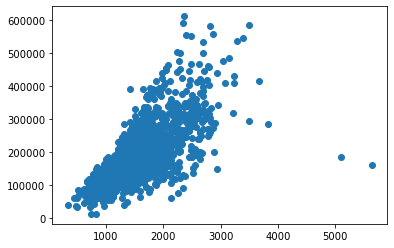

In [35]:
plt.scatter(mod['total_sf'], mod['saleprice'])

In [36]:
#removing visible outliers for total_sf
mod = mod.loc[mod['total_sf'] < 4000]

In [37]:
mod.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [38]:
mod.columns

Index(['overall_qual', 'total_bsmt_sf', 'gr_liv_area', 'full_bath',
       'fireplaces', 'garage_cars', 'garage_area', 'totrms_abvgrd',
       'saleprice', 'total_sf'],
      dtype='object')

## Model 

In [39]:
#all of the features are still only numeric
#they will all be ran through the polynomial function to be transformed, and then scaled 
X = mod.drop(columns='saleprice')
y = mod['saleprice']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [41]:
pf = PolynomialFeatures(include_bias = False)
pf.fit(X_train)

PolynomialFeatures(include_bias=False)

In [42]:
X_train_pf = pf.transform(X_train)
X_test_pf = pf.transform(X_test)
X_test_pf = pd.DataFrame(X_test_pf, columns=pf.get_feature_names(X.columns))

In [43]:
lr_pf = LinearRegression()

In [44]:
lr_pf.fit(X_train_pf, y_train)

LinearRegression()

In [45]:
#scores are higher than the first model and still close together
#made progress in adding more features to increase score, while not having too much variance, the scores
# are ~0.03 apart
print(lr_pf.score(X_test_pf, y_test))
print(lr_pf.score(X_train_pf, y_train))

0.8570923222681137
0.8863106252837224


In [46]:
sc = StandardScaler()
sc.fit(X_test_pf)

StandardScaler()

In [47]:
X_train_sc = sc.transform(X_train_pf)
X_test_sc = sc.transform(X_test_pf)
X_train_sc = pd.DataFrame(X_train_sc, columns=pf.get_feature_names(X.columns))
X_test_sc = pd.DataFrame(X_test_sc, columns=pf.get_feature_names(X.columns))

In [27]:
#scores are almost exactly the same as above after scaling 
lr_sc = LinearRegression()
lr_sc.fit(X_train_sc, y_train)
lr_sc.score(X_test_sc, y_test), lr_sc.score(X_train_sc, y_train)

(0.8649203272561473, 0.8840072796061287)

In [636]:
#cross val score is lower than above, might have too much variance 
cross_val_score(lr_sc,X_test,y_test,cv=20).mean()

0.7711350872079274

In [637]:
#RMSE is lower than the first model
y_preds_sc = lr_sc.predict(X_train_sc)
mean_squared_error(y_train, y_preds_sc, squared=False)

27033.821457427635

## Shaping and Predicting Test 

In [638]:
features = ['overall_qual', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'full_bath', 'fireplaces', 'garage_cars', 'garage_area', 'totrms_abvgrd']           

In [639]:
test = pd.read_csv('datasets/base_test.csv')
test.drop(columns='Unnamed: 0', inplace=True)

In [640]:
test = test[features]
test.head()

,overall_qual,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,full_bath,fireplaces,garage_cars,garage_area,totrms_abvgrd
0,6,1020,908,1020,1928,2,0,1,440,9
1,5,1967,1967,0,1967,2,0,2,580,10
2,7,654,664,832,1496,2,1,2,426,7
3,5,968,968,0,968,1,0,2,480,5
4,6,1394,1394,0,1394,1,2,2,514,6


In [641]:
test['total_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']
test.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [642]:
test.head()

,overall_qual,total_bsmt_sf,gr_liv_area,full_bath,fireplaces,garage_cars,garage_area,totrms_abvgrd,total_sf
0,6,1020,1928,2,0,1,440,9,1928
1,5,1967,1967,2,0,2,580,10,1967
2,7,654,1496,2,1,2,426,7,1496
3,5,968,968,1,0,2,480,5,968
4,6,1394,1394,1,2,2,514,6,1394


In [643]:
test_pf = pf.transform(test)
test_pf = pd.DataFrame(test_pf, columns=pf.get_feature_names(X.columns))

In [644]:
test_sc = sc.transform(test_pf)

In [645]:
test_sc = (pd.DataFrame(test_sc, columns=pf.get_feature_names(X.columns)))

In [646]:
y_preds = lr_sc.predict(test_sc)

In [647]:
df = pd.read_csv('datasets/test.csv')

In [648]:
submission = pd.DataFrame(df['Id'])
submission['SalePrice'] = y_preds

In [649]:
submission

,Id,SalePrice
0,2658,168182.629640
1,2718,165060.755858
2,2414,174915.435052
3,1989,125525.390851
4,625,197979.007902
...,...,...
873,1662,194208.212044
874,1234,198779.316506
875,1373,138776.206087
876,1672,105616.259188


In [548]:
submission.to_csv('submission_b.csv', index=False)